# Simple CNN for PETALO

Esta red la vamos a utilizar para obtener el radio 

In [1]:
import numpy as np
np.random.seed(1337)  # for reproducibility
import sys
print(sys.path)
sys.path.append("/home/rgadea/lmfit-py/")
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D,BatchNormalization
from keras.utils import np_utils
from math import floor
from lmfit.models import  GaussianModel
import matplotlib.pyplot as plt

['', '/home/rgadea3/anaconda3/envs/tensorflow/lib/python36.zip', '/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6', '/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6/lib-dynload', '/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6/site-packages', '/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6/site-packages/IPython/extensions', '/home/rgadea3/.ipython']


Using TensorFlow backend.


## Vamos introducir los datos de petalo preprocesados en matlab


In [2]:
import scipy.io as sio
datos_matlab = sio.loadmat('../datos_mayo_2018/conjunto_entrenamiento_mayo_2018_ring1y2_filtrado9_run200_pho_super+.mat')
conjunto_datos=datos_matlab.get('photodefbox2_todo_fil2')

## Network parameters:

In [3]:
batch_size = 500
nb_classes = 10
nb_epoch = 150

# input image dimensions
img_rows, img_cols = 16, 30
# number of convolutional filters to use
nb_filters = 32
# size of pooling area for max pooling
pool_size = (2, 2)
# convolution kernel size
kernel_size = (4, 4)

## Prepare data into training and test set.

In [4]:
# the data, shuffled and split between train and test sets
# (X_train, y_train), (X_test, y_test) = mnist.load_data()
numero_muestras=conjunto_datos.shape[0]
print(numero_muestras)
print('conjunto_datos shape:', conjunto_datos.shape)

tr_size=60
val_size=20
test_size=100-val_size-tr_size

tamanyo_tr=floor(tr_size*numero_muestras/100)
tamanyo_val=floor(val_size*numero_muestras/100)
tamanyo_test=numero_muestras-tamanyo_tr-tamanyo_val
print(tamanyo_tr)
print(tamanyo_val)
print(tamanyo_test)
XY_test=conjunto_datos[tamanyo_tr+tamanyo_val:numero_muestras,:]
XY_test_bin0=XY_test[np.where((XY_test[:,1]>=99.3128) * (XY_test[:,1]<105.3128))]
XY_test_bin1=XY_test[np.where((XY_test[:,1]>=105.3128) * (XY_test[:,1]<111.3128))]
XY_test_bin2=XY_test[np.where((XY_test[:,1]>=111.3128) * (XY_test[:,1]<117.3128))]
XY_test_bin3=XY_test[np.where((XY_test[:,1]>=117.3128) * (XY_test[:,1]<123.3128))]
XY_test_bin4=XY_test[np.where((XY_test[:,1]>=123.3128))]

X_train=conjunto_datos[:tamanyo_tr,3:483]
X_val=conjunto_datos[tamanyo_tr:tamanyo_tr+tamanyo_val,3:483]
X_test=conjunto_datos[tamanyo_tr+tamanyo_val:numero_muestras,3:483]

X_test_bin0=XY_test_bin0[:,3:483]
Y_test_bin0=XY_test_bin0[:,1]
print(X_test_bin0.shape)
X_test_bin1=XY_test_bin1[:,3:483]
Y_test_bin1=XY_test_bin1[:,1]
print(X_test_bin1.shape)
X_test_bin2=XY_test_bin2[:,3:483]
Y_test_bin2=XY_test_bin2[:,1]
print(X_test_bin2.shape)
X_test_bin3=XY_test_bin3[:,3:483]
Y_test_bin3=XY_test_bin3[:,1]
print(X_test_bin3.shape)
X_test_bin4=XY_test_bin4[:,3:483]
Y_test_bin4=XY_test_bin4[:,1]
print(X_test_bin4.shape)



Y_train=conjunto_datos[:tamanyo_tr,1] #elijo la coordenada radius
Y_val=conjunto_datos[tamanyo_tr:tamanyo_tr+tamanyo_val,1] #elijo la corrdenada radius
Y_test=conjunto_datos[tamanyo_tr+tamanyo_val:numero_muestras,1] #elijo la corrdenada radius

69146
conjunto_datos shape: (69146, 898)
41487
13829
13830
(2966, 480)
(3398, 480)
(2933, 480)
(2498, 480)
(2035, 480)


In [5]:
X_train = X_train.reshape(X_train.shape[0], img_cols, img_rows,1)
X_val = X_val.reshape(X_val.shape[0], img_cols, img_rows,1)
X_test = X_test.reshape(X_test.shape[0], img_cols, img_rows,1)

X_test_bin0 = X_test_bin0.reshape(X_test_bin0.shape[0], img_cols, img_rows,1)
X_test_bin1 = X_test_bin1.reshape(X_test_bin1.shape[0], img_cols, img_rows,1)
X_test_bin2 = X_test_bin2.reshape(X_test_bin2.shape[0], img_cols, img_rows,1)
X_test_bin3 = X_test_bin3.reshape(X_test_bin3.shape[0], img_cols, img_rows,1)
X_test_bin4 = X_test_bin4.reshape(X_test_bin4.shape[0], img_cols, img_rows,1)

input_shape = (img_cols, img_rows,1)
#input_shape=input_shape.astype('int32')

In [6]:
X_train = X_train.astype('float32')
X_val= X_val.astype('float32')
X_test = X_test.astype('float32')

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_val.shape[0], 'validation samples')
print(X_test.shape[0], 'test samples')

X_train shape: (41487, 30, 16, 1)
41487 train samples
13829 validation samples
13830 test samples


Display 20 random training images using image

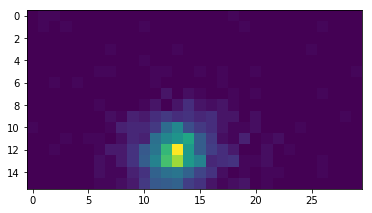

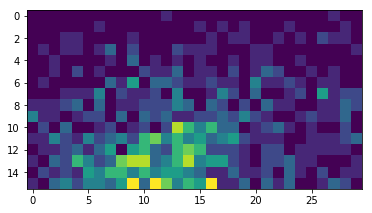

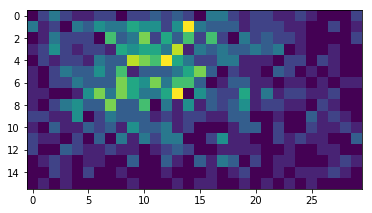

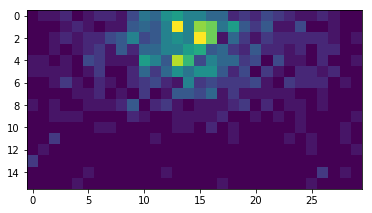

In [7]:
# convert class vectors to binary class matrices
#Y_train = np_utils.to_categorical(y_train, nb_classes)
#Y_test = np_utils.to_categorical(y_test, nb_classes)
for i in range(1,5):
    idea=np.random.randint(1,X_train.shape[0])
    plt.imshow(np.reshape(X_train[idea].transpose(), [16, 30]), cmap='viridis')
    plt.show()

## Build the CNN. 

In [8]:
model = Sequential()

model.add(Conv2D(8, kernel_size=kernel_size,
                        padding='same',
                        input_shape=(30,16,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))

model.add(Conv2D(16, kernel_size, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))

model.add(Conv2D(32, kernel_size, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(64, kernel_size, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(1))


model.compile(loss='mean_squared_error',
              optimizer='rmsPROP',
              metrics=['mae','acc'])


Show a summary of the model parameters. 

In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 16, 8)         136       
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 16, 8)         32        
_________________________________________________________________
activation_1 (Activation)    (None, 30, 16, 8)         0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 8, 8)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 8, 16)         2064      
_________________________________________________________________
batch_normalization_2 (Batch (None, 15, 8, 16)         64        
_________________________________________________________________
activation_2 (Activation)    (None, 15, 8, 16)         0         
__________

And now train the model and evaluate on the test set. 

In [10]:
history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch,
          verbose=1, validation_data=(X_val, Y_val))

Train on 41487 samples, validate on 13829 samples
Epoch 1/150
41487/41487 [==============================] - 6s 137us/step - loss: 2683.2367 - mean_absolute_error: 42.9387 - acc: 0.0000e+00 - val_loss: 259.0277 - val_mean_absolute_error: 15.8470 - val_acc: 0.0000e+00
Epoch 2/150
41487/41487 [==============================] - 2s 50us/step - loss: 12.5715 - mean_absolute_error: 2.7070 - acc: 0.0000e+00 - val_loss: 138.7864 - val_mean_absolute_error: 11.6197 - val_acc: 0.0000e+00
Epoch 3/150
41487/41487 [==============================] - 2s 51us/step - loss: 8.9775 - mean_absolute_error: 2.3550 - acc: 0.0000e+00 - val_loss: 3.5584 - val_mean_absolute_error: 1.4862 - val_acc: 0.0000e+00
Epoch 4/150
41487/41487 [==============================] - 2s 50us/step - loss: 8.1804 - mean_absolute_error: 2.2466 - acc: 0.0000e+00 - val_loss: 8.6809 - val_mean_absolute_error: 2.5878 - val_acc: 0.0000e+00
Epoch 5/150
41487/41487 [==============================] - 2s 51us/step - loss: 7.6575 - mean_abso

41487/41487 [==============================] - 2s 50us/step - loss: 5.0282 - mean_absolute_error: 1.7630 - acc: 0.0000e+00 - val_loss: 0.7719 - val_mean_absolute_error: 0.5614 - val_acc: 0.0000e+00
Epoch 40/150
41487/41487 [==============================] - 2s 50us/step - loss: 5.1374 - mean_absolute_error: 1.7820 - acc: 0.0000e+00 - val_loss: 1.7203 - val_mean_absolute_error: 1.0435 - val_acc: 0.0000e+00
Epoch 41/150
41487/41487 [==============================] - 2s 50us/step - loss: 5.2826 - mean_absolute_error: 1.8064 - acc: 0.0000e+00 - val_loss: 0.9102 - val_mean_absolute_error: 0.6545 - val_acc: 0.0000e+00
Epoch 42/150
41487/41487 [==============================] - 2s 51us/step - loss: 5.1696 - mean_absolute_error: 1.7847 - acc: 0.0000e+00 - val_loss: 1.1770 - val_mean_absolute_error: 0.8020 - val_acc: 0.0000e+00
Epoch 43/150
41487/41487 [==============================] - 2s 50us/step - loss: 5.1756 - mean_absolute_error: 1.7906 - acc: 0.0000e+00 - val_loss: 4.3608 - val_mean_abs

Epoch 78/150
41487/41487 [==============================] - 2s 50us/step - loss: 4.7899 - mean_absolute_error: 1.7203 - acc: 0.0000e+00 - val_loss: 0.7295 - val_mean_absolute_error: 0.5546 - val_acc: 0.0000e+00
Epoch 79/150
41487/41487 [==============================] - 2s 49us/step - loss: 4.6812 - mean_absolute_error: 1.7059 - acc: 0.0000e+00 - val_loss: 1.4739 - val_mean_absolute_error: 0.9616 - val_acc: 0.0000e+00
Epoch 80/150
41487/41487 [==============================] - 2s 50us/step - loss: 4.8282 - mean_absolute_error: 1.7272 - acc: 0.0000e+00 - val_loss: 0.6448 - val_mean_absolute_error: 0.4934 - val_acc: 0.0000e+00
Epoch 81/150
41487/41487 [==============================] - 2s 50us/step - loss: 4.6846 - mean_absolute_error: 1.7014 - acc: 0.0000e+00 - val_loss: 0.7059 - val_mean_absolute_error: 0.5341 - val_acc: 0.0000e+00
Epoch 82/150
41487/41487 [==============================] - 2s 49us/step - loss: 4.7642 - mean_absolute_error: 1.7155 - acc: 0.0000e+00 - val_loss: 0.7776 -

Epoch 117/150
41487/41487 [==============================] - 2s 50us/step - loss: 4.4802 - mean_absolute_error: 1.6626 - acc: 0.0000e+00 - val_loss: 0.7233 - val_mean_absolute_error: 0.5749 - val_acc: 0.0000e+00
Epoch 118/150
41487/41487 [==============================] - 2s 50us/step - loss: 4.5179 - mean_absolute_error: 1.6691 - acc: 0.0000e+00 - val_loss: 1.0396 - val_mean_absolute_error: 0.7393 - val_acc: 0.0000e+00
Epoch 119/150
41487/41487 [==============================] - 2s 50us/step - loss: 4.4805 - mean_absolute_error: 1.6619 - acc: 0.0000e+00 - val_loss: 0.9789 - val_mean_absolute_error: 0.7151 - val_acc: 0.0000e+00
Epoch 120/150
41487/41487 [==============================] - 2s 50us/step - loss: 4.4784 - mean_absolute_error: 1.6658 - acc: 0.0000e+00 - val_loss: 4.2005 - val_mean_absolute_error: 1.8940 - val_acc: 0.0000e+00
Epoch 121/150
41487/41487 [==============================] - 2s 49us/step - loss: 4.4225 - mean_absolute_error: 1.6554 - acc: 0.0000e+00 - val_loss: 1.3

In [11]:
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test mse:', score[0])
print('Test mae:', score[1])
Y_test_predicted=model.predict(X_test)
print(Y_test_predicted[:10].flatten())
print(Y_test[:10])
error_prediction=Y_test-Y_test_predicted.flatten()

print(error_prediction[:10])

Test mse: 3.5119165264344785
Test mae: 1.717477548303418
[119.74706 105.6416  106.44967 113.09044 117.50334 108.24088 119.45312
 119.84224 111.64667 126.42417]
[118.82385271 101.02609008 104.79797404 111.5215145  116.83772997
 106.34918459 117.56790416 118.66904891 108.86355043 124.86360843]
[-0.92320997 -4.61551148 -1.65169485 -1.56892435 -0.66561171 -1.89169828
 -1.88521321 -1.17319047 -2.78311705 -1.56056302]


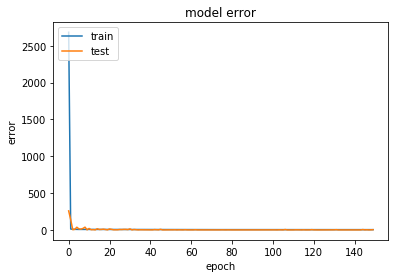

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model error')
plt.ylabel('error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [13]:
#print(error_prediction)

/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


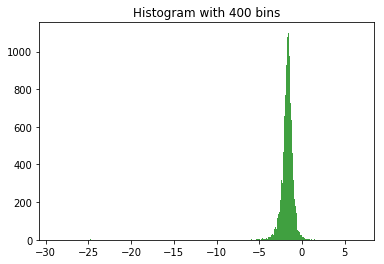

(400,)
(401,)
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 400
    # variables        = 3
    chi-square         = 9417998.00
    reduced chi-square = 23722.9169
    Akaike info crit   = 4032.66742
    Bayesian info crit = 4044.64181
[[Variables]]
    amp: -2.6941e-06 +/- 178.060953 (6609293723.93%) (init = 1000)
    cen:  1.96486495 +/- 237.843157 (12104.81%) (init = 0)
    wid:  0.08352966 +/- 324.515389 (388503.18%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, wid) = -0.601
    C(cen, wid) = -0.356
    C(amp, cen) =  0.271



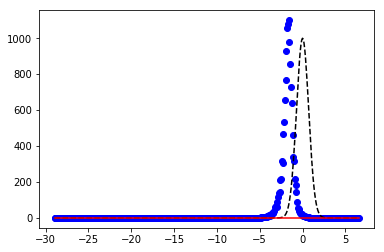

In [14]:

n, bins, patches = plt.hist(error_prediction, 400, normed=0, facecolor='green', alpha=0.75)
plt.title("Histogram with 400 bins")
plt.show()
x=bins[:400]
y=n
print(n.shape)
print(bins.shape)
from numpy import exp, loadtxt, pi, sqrt, log

from lmfit import Model
def gaussian(x, amp, cen, wid):
    """1-d gaussian: gaussian(x, amp, cen, wid)"""
    return amp * exp(-((x-cen)/wid)**2 )


gmodel = Model(gaussian)
result = gmodel.fit(y, x=x, amp=1000, cen=0, wid=1)

print(result.fit_report())

plt.plot(x, y, 'bo')
plt.plot(x, result.init_fit, 'k--')
plt.plot(x, result.best_fit, 'r-')
plt.show()





In [15]:
FWHM=result.params['wid'].value*2*sqrt(log(2))

In [16]:
print(FWHM)

0.13908601021605793


[[105.6416  ]
 [106.44967 ]
 [105.669075]
 ...
 [107.59503 ]
 [103.90592 ]
 [103.50673 ]]


/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


-1.6183693639453476


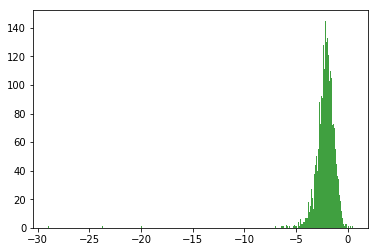

In [17]:
Y_test_bin0_predicted=model.predict(X_test_bin0)
print(Y_test_bin0_predicted)
error_prediction_bin0=Y_test_bin0-Y_test_bin0_predicted.flatten()
n, bins, patches = plt.hist(error_prediction_bin0, 400, normed=0, facecolor='green', alpha=0.75)

x=bins[:400]
y=n

gmodel = Model(gaussian)
result = gmodel.fit(y, x=x, amp=1000, cen=0, wid=1)
FWHM_bin0=result.params['wid'].value*2*sqrt(log(2))
print(FWHM_bin0)

/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


-0.557032556895074


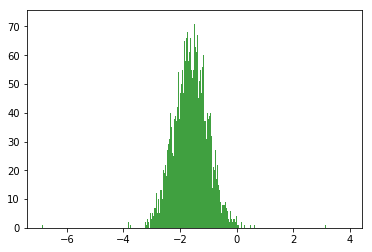

In [18]:
Y_test_bin1_predicted=model.predict(X_test_bin1)
#print(Y_test_bin1_predicted)
error_prediction_bin1=Y_test_bin1-Y_test_bin1_predicted.flatten()
n, bins, patches = plt.hist(error_prediction_bin1, 400, normed=0, facecolor='green', alpha=0.75)

x=bins[:400]
y=n

gmodel = Model(gaussian)
result = gmodel.fit(y, x=x, amp=1000, cen=0, wid=1)
FWHM_bin1=result.params['wid'].value*2*sqrt(log(2))
print(FWHM_bin1)

/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


0.8671650241583482


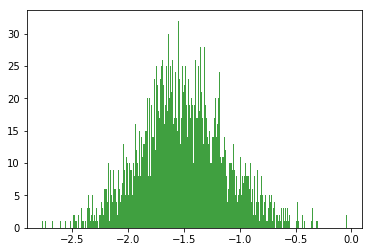

In [19]:
Y_test_bin2_predicted=model.predict(X_test_bin2)
#print(Y_test_bin2_predicted)
error_prediction_bin2=Y_test_bin2-Y_test_bin2_predicted.flatten()
n, bins, patches = plt.hist(error_prediction_bin2, 400, normed=0, facecolor='green', alpha=0.75)

x=bins[:400]
y=n

gmodel = Model(gaussian)
result = gmodel.fit(y, x=x, amp=1000, cen=0, wid=1)
FWHM_bin2=result.params['wid'].value*2*sqrt(log(2))
print(FWHM_bin2)

/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


0.6719508151581625


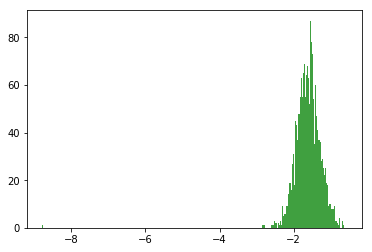

In [20]:
Y_test_bin3_predicted=model.predict(X_test_bin3)
#print(Y_test_bin3_predicted)
error_prediction_bin3=Y_test_bin3-Y_test_bin3_predicted.flatten()
n, bins, patches = plt.hist(error_prediction_bin3, 400, normed=0, facecolor='green', alpha=0.75)

x=bins[:400]
y=n

gmodel = Model(gaussian)
result = gmodel.fit(y, x=x, amp=1000, cen=0, wid=1)
FWHM_bin3=result.params['wid'].value*2*sqrt(log(2))
print(FWHM_bin3)

/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


-0.7967640804126275
0.6719508151581625
0.8671650241583482
-0.557032556895074
-1.6183693639453476


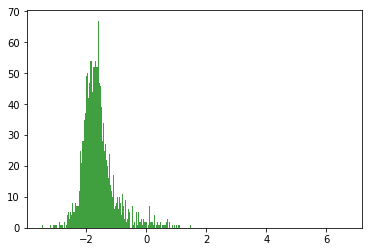

In [21]:
Y_test_bin4_predicted=model.predict(X_test_bin4)
#print(Y_test_bin4_predicted)
error_prediction_bin4=Y_test_bin4-Y_test_bin4_predicted.flatten()
n, bins, patches = plt.hist(error_prediction_bin4, 400, normed=0, facecolor='green', alpha=0.75)

x=bins[:400]
y=n

gmodel = Model(gaussian)
result = gmodel.fit(y, x=x, amp=1000, cen=0, wid=1)
FWHM_bin4=result.params['wid'].value*2*sqrt(log(2))
print(FWHM_bin4)
print(FWHM_bin3)
print(FWHM_bin2)
print(FWHM_bin1)
print(FWHM_bin0)